In [1]:
import json
import lightgbm as lgb
import shap
import tensorflow as tf
import anndata
from matplotlib import pyplot as plt
import numpy as np
import joblib
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
import cv2
import pandas as pd
import PIL
from PIL import Image
import random
import scipy as sp
import umap
from scipy import ndimage as ndi
import joblib
import sys
import scanpy as sc
import skimage
from scipy.stats import nbinom

import pickle

from skimage.transform import resize
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries, watershed
from skimage.segmentation import slic
from skimage.morphology import area_opening

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image as image_fun
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_fun
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

In [2]:
def watershed_segment(image):
    """
    Segments nuclei in an image using the watershed algorithm.

    Args:
        image: The input image to segment.

    Returns:
        A segmentation mask where each pixel is assigned a unique integer
        representing the nucleus it belongs to.
    """

    # Convert the image to HED color space
    annotation_hed = rgb2hed(image)

    # Extract the hematoxylin channel
    annotation_h = annotation_hed[:, :, 0]

    # Normalize the hematoxylin channel
    annotation_h *= 255.0 / np.percentile(annotation_h, q=0.01)

    # Apply Otsu thresholding with a slight adjustment
    thresh = skimage.filters.threshold_otsu(annotation_h) * 0.7

    # Create a foreground mask and fill holes
    im_fgnd_mask = sp.ndimage.binary_fill_holes(annotation_h < thresh)

    # Calculate the distance transform of the foreground mask
    distance = ndi.distance_transform_edt(im_fgnd_mask)

    # Identify local maxima as potential markers for watershed segmentation
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)

    # Create a marker mask based on the identified local maxima
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)

    # Apply watershed segmentation to the hematoxylin channel, using the markers and foreground mask
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)

    # Remove small segments using area opening
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int32)

    # Relabel segments with consecutive integers for consistency
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)

    return im_nuclei_seg_mask

#####################

def model_predict_gene_nb(gene):
    """
    Creates a prediction function for a specific gene,
    incorporating negative binomial model parameters and formatting output.

    Args:
        gene: The name of the gene to focus on.

    Returns:
        A prediction function that takes input data and returns
        formatted predictions for the gene based on negative binomial modeling.
    """

    i = gene_list.index(gene)  # Find the index of the gene in the list

    from scipy.stats import nbinom  # Import for negative binomial calculations

    def model_predict(x):
        """
        Predicts using negative binomial parameters and formats output.

        Args:
            x: The input data for prediction.

        Returns:
            A 2D array of formatted predictions for the gene.
        """

        # Get model predictions for the input data
        test_predictions = model.predict(x)

        # Extract negative binomial parameters for the specified gene
        n = test_predictions[i][:, 0]  # Shape parameter (number of failures before success)
        p = test_predictions[i][:, 1]  # Probability of success

        # Calculate mean based on negative binomial distribution
        y_pred = nbinom.mean(n, p)

        # Reshape the predictions for consistency
        y_pred = y_pred.reshape(-1, 1)

        return y_pred

    return model_predict

#####################

def model_predict_gene_dl(gene):
    """
    Creates a prediction function for a specific gene using a deep learning model.

    Args:
        gene: The name of the gene to create the prediction function for.

    Returns:
        A function that takes a tile as input and returns the model's prediction for that tile,
        formatted as a probability for the presence of the gene and its complement.
    """

    # Get the index of the gene in the gene list
    i = gene_list.index(gene)

    # Define the inner prediction function
    def combine_model_predict(tile1):
        """
        Predicts the probability of the gene and its complement for a given tile.

        Args:
            tile1: The input tile to make a prediction on.

        Returns:
            A NumPy array containing the predicted probabilities for the gene and its complement.
        """

        # Get the raw prediction from the model
        prediction = model.predict(tile1)

        # Extract the prediction for the specific gene
        gene_prediction = prediction[i]

        # Calculate the prediction for the gene's complement
        complement_prediction = 1 - gene_prediction

        # Combine the predictions into a single array
        combined_prediction = np.append(gene_prediction, complement_prediction, axis=1)

        return combined_prediction

    return combine_model_predict

#####################

def model_predict_gene_ml(gene):
    """
    Creates a prediction function for a specific gene using a machine learning classifier.

    Args:
        gene: The name of the gene to create the prediction function for.

    Returns:
        A function that takes a tile as input and returns the classifier's predicted probability
        for the presence of the gene in that tile.
    """

    # Get the index of the gene in the gene list
    i = gene_list.index(gene)

    # Define the inner prediction function
    def combine_model_predict(tile1):
        """
        Predicts the probability of the gene in a given tile.

        Args:
            tile1: The input tile to make a prediction on.

        Returns:
            The predicted probability of the gene being present in the tile.
        """

        # Extract features from the tile using the ResNet model
        feature1 = resnet_model.predict(tile1)

        # Use the classifier to predict probabilities based on the features
        prediction = clf_resnet.predict_proba(feature1)

        # Extract the prediction for the specific gene
        gene_prediction = prediction[i]

        return gene_prediction

    return combine_model_predict

#####################

def model_predict_gene_kernel(gene):
    """
    Creates a specialized prediction function for a specific gene,
    combining model prediction with masking and probability adjustment.

    Args:
        gene: The name of the gene to focus on.

    Returns:
        A function that takes a binary mask matrix as input and
        returns adjusted model predictions for the specified gene.
    """

    i = gene_list.index(gene)  # Find the index of the gene in the list

    def combine_model_predict(z):
        """
        Predicts using the masked image and adjusts probabilities.

        Args:
            z: A binary mask matrix indicating which segments to mask.

        Returns:
            A prediction array with adjusted probabilities for the gene.
        """

        # Mask the image based on the segmentation and mask matrix
        masked_image = mask_image(z, segments_slic, image_orig, 0)
        
# ####################   If model is a machine learning classifier  ####################        
        # Extract ResNet50 features
        feature1 = resnet_model.predict(mask_image(z, segments_slic, image_orig, 0))
        
        # Run Logistic Regression
        prediction = model_c.predict_proba(feature1)

# ####################   If model is a deep learning classifier  ####################
#         # Get model predictions for the masked image
#         prediction = model.predict(masked_image)

#         # Extract the prediction probabilities for the specified gene
#         gene_probabilities = prediction[i]

#         # Append the complement of the gene's prediction probabilities
#         # to create a 2-column output
#         adjusted_prediction = np.append(gene_probabilities, 1 - gene_probabilities, axis=1)

        return prediction[i]
    return combine_model_predict

#####################

def model_predict_gene_kernel_reg(gene):
    """
    Creates a specialized prediction function for a specific gene,
    combining model prediction with masking and probability adjustment.

    Args:
        gene: The name of the gene to focus on.

    Returns:
        A function that takes a binary mask matrix as input and
        returns adjusted model predictions for the specified gene.
    """

    i = 282 #gene_list.index(gene)  # Find the index of the gene in the list
    def combine_model_predict(z):
        """
        Predicts using the masked image and adjusts probabilities.

        Args:
            z: A binary mask matrix indicating which segments to mask.

        Returns:
            A prediction array with adjusted probabilities for the gene.
        """
        masked_image = mask_image(z, segments_slic, image_orig, 0)
        test_predictions = model.predict(masked_image[0].reshape(1,299,299,3))
        n = test_predictions[i][:, 0]
        p = test_predictions[i][:, 1]
        y_pred = nbinom.mean(n, p)
        return y_pred.reshape(-1,1)
    return combine_model_predict


#####################

def LIME(image_path, gene):
    """
    Generates LIME heatmaps for a specific gene across multiple images.

    Args:
        image_path: A list of image paths to process.
        gene: The name of the gene to analyze.

    Returns:
        A list of LIME heatmaps, one for each image.
    """

    LIME_heatmaps = []

    for i in image_path:
        # Load the image
        image = np.asarray(image_fun.load_img(i))

        # Generate LIME explanation for the image and gene
        explanation = explainer.explain_instance(
            image,
            model_predict_gene_dl(gene),
            top_labels=2,
            hide_color=0,
            num_samples=100,
            segmentation_fn=watershed_segment
        )

        # Extract the heatmap from the explanation
        temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=100, hide_rest=True)
        dict_heatmap = dict(explanation.local_exp[1])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

        # Append the heatmap to the list
        LIME_heatmaps.append(heatmap)

    return LIME_heatmaps

#####################

def LIME_exceptional_handling(image_path, gene):
    """
    Generates LIME explanations for a gene across multiple images, handling exceptions.

    Args:
        image_path: A list of image paths to process.
        gene: The name of the gene to analyze.

    Returns:
        A list of LIME heatmaps, one for each successfully processed image.
    """

    LIME_heatmaps = []
    no_segments = []

    for i in image_path:
        # Load the image
        image = np.asarray(image_fun.load_img(i))

        try:
            # Generate LIME explanation for the image and gene
            explanation = explainer.explain_instance(
                image,
                model_predict_gene_dl(gene),
                top_labels=2,
                hide_color=0,
                num_samples=100,
                segmentation_fn=watershed_segment
            )

            # Extract the heatmap from the explanation
            temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=100, hide_rest=True)
            dict_heatmap = dict(explanation.local_exp[1])
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

        except:
            # Handle exceptions, potentially due to segmentation issues
            no_segments.append(i)
            print(f"Error generating LIME explanation for image: {i}")  # Print informative error message
            heatmap = np.full((299, 299), 2)  # Set heatmap to 2s for clarity in downstream usage
        # Append the heatmap (or None for exceptions) to the list
        LIME_heatmaps.append(heatmap)

    # Print a summary of images that failed segmentation
    print(f"Images with segmentation issues: {no_segments}")

    return LIME_heatmaps

#####################

def LIME_reg_exceptional_handling(image_path, gene):
    """
    Generates LIME explanations for a gene across multiple images, handling exceptions.

    Args:
        image_path: A list of image paths to process.
        gene: The name of the gene to analyze.

    Returns:
        A list of LIME heatmaps, one for each successfully processed image.
    """
    LIME_heatmaps = []
    no_segments = []
    
    for i in image_path:
    # Load the image
        image = np.asarray(Image.open(image_path))
        try:
            # Generate LIME explanation for the image and gene
            explanation = explainer.explain_instance(
                image,
                model_predict_gene_reg(gene),
                top_labels=1,
                hide_color=0,
                num_samples=1000,
                segmentation_fn=watershed_segment)
            dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
            heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    
        except:
            # Handle exceptions, potentially due to segmentation issues
            no_segments.append(i)
            print(f"Error generating LIME explanation for image: {i}")  # Print informative error message
            heatmap = np.full((299, 299), 2)  # Set heatmap to 2s for clarity in downstream usage
        # Append the heatmap (or None for exceptions) to the list
        LIME_heatmaps.append(heatmap)

    # Print a summary of images that failed segmentation
    print(f"Images with segmentation issues: {no_segments}")

    return LIME_heatmaps

##################################

def SHAP_global(image_path, gene):
    """
    Calculates global SHAP values for a specific gene across multiple images.

    Args:
        image_path: A list of image paths to process.
        gene: The name of the gene to analyze.

    Returns:
        A list of SHAP values, one for each image.
    """

    SHAP_mask = []

    for i in image_path:
        # Create an image masker using the "inpaint_telea" method
        masker = shap.maskers.Image("inpaint_telea", (299, 299, 3))

        # Create a SHAP explainer for the deep learning model and gene
        explainer_shap = shap.Explainer(model_predict_gene_dl(gene), masker, output_names=STimage_classification_classes)

        # Load the image, preprocess it, and reshape it for the model
        image = np.array(plt.imread(i)).astype('float32').reshape(1, 299, 299, 3)

        # Calculate SHAP values for the image
        shap_values = explainer_shap(image, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

        # Append the SHAP values to the list
        SHAP_mask.append(shap_values)

    return SHAP_mask

#####################

def mask_image(zs, segmentation, image, background=None):
    """
    Masks an image based on a segmentation map and a binary mask matrix.

    Args:
        zs: A binary mask matrix with shape (N, M), where N is the number of masks
             and M is the number of segments. Each element zs[i, j] indicates whether
             to mask segment j in mask i.
        segmentation: A segmentation map with shape (H, W) representing pixel-wise
                      segment labels.
        image: The input image to be masked.
        background: (optional) The background value to use for masked pixels. If not
                     provided, the mean pixel value of the image is used.

    Returns:
        A masked image with shape (N, H, W, C), where each image in the first dimension
        corresponds to a different masking configuration based on the zs matrix.
    """

    # If no background value is provided, use the mean pixel value of the image
    if background is None:
        background = image.mean((0, 1))  # Calculate mean across spatial dimensions

    # Create an output array to store the masked images
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))

    # Iterate through each mask in the zs matrix
    for i in range(zs.shape[0]):
        # Copy the original image to the current output frame
        out[i, :, :, :] = image

        # Iterate through each segment in the segmentation map
        for j in range(zs.shape[1]):
            # If the corresponding value in zs is 0 (indicating masking)
            if zs[i, j] == 0:
                # Replace the pixels in the segment with the background value
                out[i][segmentation == j, :] = background

    return out

#####################

def fill_segmentation(values, segmentation):
    """
    Fills a segmentation map with corresponding values based on segment labels.

    Args:
        values: A list or array of values to assign to each segment.
        segmentation: A NumPy array representing the segmentation map, where each pixel
                      value indicates its segment label.

    Returns:
        A NumPy array with the same shape as the segmentation map, where each pixel
        is filled with the corresponding value from the `values` list.
    """

    # Create an output array with the same shape as the segmentation map
    out = np.zeros(segmentation.shape)

    # Iterate through each value-segment pair
    for i in range(len(values)):
        # Find the pixels in the segmentation map that belong to the current segment
        segment_pixels = segmentation == i

        # Assign the corresponding value to those pixels in the output array
        out[segment_pixels] = values[i]

    return out

#####################

def scale_mask(mat, N):
    """
    Scales a mask matrix to the range [0, 1].

    Args:
        mat: The input mask matrix to be scaled.
        N: The number of masks in the matrix.

    Returns:
        The scaled mask matrix with values in the range [0, 1].
    """

    # Reshape the matrix into a 2D matrix with N rows and 89401 columns
    mat = mat.reshape(-1, N * 89401)

    # Normalize the matrix values to the range [0, 1] using min-max scaling
    mat_std = (mat - mat.min()) / (mat.max() - mat.min())

    # Apply a linear transformation to scale the values to the range [0, 1] explicitly
    mat_scaled = mat_std * (1 - 0) + 0  # This step is essentially identity, likely for clarity

    # Reshape the matrix back to its original shape (N, 299, 299)
    return mat_scaled.reshape(N, 299, 299)

#####################

def SHAP_scale(ShapMask, N):
    """
    Processes SHAP masks for scaling and visualization.

    Args:
        ShapMask: A list of SHAP mask objects.
        N: The number of masks in the list.

    Returns:
        A scaled version of the SHAP masks, suitable for visualization.
    """

    # Create lists to store the high-contribution mask values
    ShapMask_high = []
    ShapMask_high_1c = []

    # Extract the mask values with the highest contribution for each channel
    for i in range(N):
        # Get the index of the channel with the highest base value
        max_base_value_index = np.argmax(ShapMask[i].base_values)

        # Extract the mask values for that channel
        ShapMask_high.append(ShapMask[i].values[:, :, :, :, max_base_value_index])

    # Reshape the mask values into a 4D array
    ShapMask_high = np.array(ShapMask_high).reshape(N, 299, 299, 3)

    # Select only the first color channel (assuming RGB format)
    for i in range(N):
        ShapMask_high_1c.append(ShapMask_high[i, :, :, :1])

    # Convert to a NumPy array
    ShapMask_high_1c = np.array(ShapMask_high_1c)

    # Scale the masks for visualization
    return scale_mask(ShapMask_high_1c, N)

#####################

def LIME_segment_score(image_path, Lime_mask_scaled):
    """
    Calculates LIME scores for individual segments within images.

    Args:
        image_path: A list of paths to the images to analyze.
        Lime_mask_scaled: A list of LIME heatmaps (scaled 0-1), one for each image.

    Returns:
        A list of lists, where each inner list contains the average LIME score
        for each segmented object in the corresponding image.
    """

    lime_seg_score = []

    for num, x in enumerate(image_path):
        # Get watershed segmentation mask for the image
        watershed_mask = watershed_segment(Image.open(x))

        # Get the corresponding LIME heatmap
        lime_score = Lime_mask_scaled[num]

        # Identify unique segment IDs in the watershed mask (excluding background)
        unique_objects = np.unique(watershed_mask)
        unique_objects = unique_objects[unique_objects != 0]

        average_values = []
        for obj in unique_objects:
            # Find indices of pixels belonging to the current segment
            indices = np.where(watershed_mask == obj)

            # Calculate the average LIME score within those pixels
            avg_value = np.mean(lime_score[indices])

            # Append the average score for the segment
            average_values.append(avg_value)

        # Append the scores for all segments in the image
        lime_seg_score.append(average_values)

    return lime_seg_score

#####################

def LIME_compare(gene2_LimeMask_scaled, gene1_LimeMask_scaled):
    """
    Compares LIME explanations for two classes by creating difference images.

    Args:
        gene2_LimeMask_scaled: A list of LIME heatmaps (scaled 0-1) for class gene2.
        gene1_LimeMask_scaled: A list of LIME heatmaps (scaled 0-1) for class gene1.

    Returns:
        A list of difference images, where each pixel represents the difference
        in LIME scores between the corresponding pixels in the gene2 and gene1 heatmaps.
    """

    gene2_list = []
    gene1_list = []
    gene2_gene1 = []

    # Create blank background arrays for RGB conversion
    a = np.array([[255]*299]*299)
    b = np.array([[255]*299]*299)

    # Process gene2 heatmaps
    for i in range(len(gene2_LimeMask_scaled)):
        rgb_uint8 = (np.dstack((gene2_LimeMask_scaled[i], a, b)) * 255).astype(np.uint8)

        # Highlight important regions in green
        black_pixels = np.where((rgb_uint8[:, :, 0] < 15) & (rgb_uint8[:, :, 1] < 15) & (rgb_uint8[:, :, 2] < 15))
        rgb_uint8[black_pixels] = [0, 255, 0]

        # Set background pixels to white
        rgb_uint8_im = Image.fromarray(rgb_uint8)
        rgb_uint8_im_info = max(rgb_uint8_im.getcolors(rgb_uint8_im.size[0] * rgb_uint8_im.size[1]))
        bcg_pixels = np.where((rgb_uint8[:, :, 0] == rgb_uint8_im_info[1][0]) &
                               (rgb_uint8[:, :, 1] == rgb_uint8_im_info[1][1]) &
                               (rgb_uint8[:, :, 2] == rgb_uint8_im_info[1][2]))
        rgb_uint8[bcg_pixels] = [255, 255, 255]

        gene2_list.append(rgb_uint8)

    # Perform the same processing for gene1 heatmaps
    for i in range(0,len(gene1_LimeMask_scaled)):
        rgb_uint8 = (np.dstack((gene1_LimeMask_scaled[i],
                                a,b))*255).astype(np.uint8)
        black_pixels = np.where(
            (rgb_uint8[:, :, 0] < 15) & 
            (rgb_uint8[:, :, 1] < 15) & 
            (rgb_uint8[:, :, 2] < 15)
        )
        rgb_uint8[black_pixels] = [0, 255, 0]

        rgb_uint8_im = Image.fromarray(rgb_uint8)
        rgb_uint8_im_info = max(rgb_uint8_im.getcolors(rgb_uint8_im.size[0]*rgb_uint8_im.size[1]))

        bcg_pixels = np.where(
            (rgb_uint8[:, :, 0] == rgb_uint8_im_info[1][0]) & 
            (rgb_uint8[:, :, 1] == rgb_uint8_im_info[1][1]) & 
            (rgb_uint8[:, :, 2] == rgb_uint8_im_info[1][2])
        )
        rgb_uint8[bcg_pixels] = [255, 255, 255]
        gene1_list.append(rgb_uint8)
    
    for i in range(0,len(gene2_list)):
        gene2_gene1.append(gene2_list[i]-gene1_list[i])
    return gene2_gene1

#####################

def negative_binomial_layer(x):
    num_dims = len(x.get_shape())
    n, p = tf.unstack(x, num=2, axis=-1)
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    n = tf.keras.activations.softplus(n)
    p = tf.keras.activations.sigmoid(p)
    out_tensor = tf.concat((n, p), axis=num_dims - 1)
    return out_tensor

#####################

def negative_binomial_loss(y_true, y_pred):
    n, p = tf.unstack(y_pred, num=2, axis=-1)
    n = tf.expand_dims(n, -1)
    p = tf.expand_dims(p, -1)
    nll = (
            tf.math.lgamma(n)
            + tf.math.lgamma(y_true + 1)
            - tf.math.lgamma(n + y_true)
            - n * tf.math.log(p)
            - y_true * tf.math.log(1 - p)
    )
    return nll

#####################

def CNN_NB_multiple_genes(tile_shape, n_genes, ft=False):
    tile_input = Input(shape=tile_shape, name="tile_input")
    cnn_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
    
    if not ft:
        for i in cnn_base.layers:
            i.trainable = False
    cnn = cnn_base.output
    cnn = GlobalAveragePooling2D()(cnn)

    output_layers = []
    for i in range(n_genes):
        output = Dense(2)(cnn)
        output_layers.append(Lambda(negative_binomial_layer, name="gene_{}".format(i))(output))

    model = Model(inputs=tile_input, outputs=output_layers)
    optimizer = tf.keras.optimizers.Adam(1e-5)
    model.compile(loss=negative_binomial_loss,
                  optimizer=optimizer)
    return model

In [3]:
# def model_predict_gene_kernel_reg(gene):
#     i = gene_list.index(gene)  # Find the index of the gene in the list
#     def combine_model_predict(z):
#         masked_image = mask_image(z, segments_slic, image_orig, 0)
#         test_predictions = model.predict(masked_image)
#         n = test_predictions[i][:, 0]
#         p = test_predictions[i][:, 1]
#         y_pred = nbinom.mean(n, p)
#         return y_pred.reshape(-1,1)
#     return combine_model_predict

# def model_predict_gene_kernel(gene):
#     i = gene_list.index(gene)  # Find the index of the gene in the list
#     def combine_model_predict(z):
#         masked_image = mask_image(z, segments_slic, image_orig, 0)
#         feature1 = resnet_model.predict(masked_image)
#         prediction = model_c.predict_proba(feature1)
#         gene_probabilities = prediction[i]
#         return gene_probabilities
#     return combine_model_predict

# def mask_image(zs, segmentation, image, background=None):
#     if background is None:
#         background = image.mean((0, 1))  # Calculate mean across spatial dimensions
#     out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
#     for i in range(zs.shape[0]):
#         out[i, :, :, :] = image
#         for j in range(zs.shape[1]):
#             if zs[i, j] == 0:
#                 out[i][segmentation == j, :] = background
#     return out

In [4]:
DATA_PATH = "/QRISdata/Q2051/Onkar/STimage/"
adata_all = anndata.read_h5ad(DATA_PATH+"all_adata.h5ad")
adata_all.obs["tile_path"] = DATA_PATH+"tiles/tiles/"+adata_all.obs["tile_path"].str.split('/', expand=True)[6]

top300_pred_genes = pd.read_csv(DATA_PATH+"stimage_LOOCV_9visium_top300gene.csv")
gene_list = list(set(top300_pred_genes["Gene"]))
n_genes = len(gene_list)
adata_all = adata_all[:,gene_list]

test_index_1160920F = adata_all.obs.library_id == "1160920F"
test_dataset_FFPE = adata_all[test_index_1160920F,].copy()

test_index_FFPE = adata_all.obs.library_id == "FFPE"
test_dataset_FFPE = adata_all[test_index_FFPE,].copy()

## Deep Learning Model
# model = tf.keras.models.load_model("/QRISdata/Q1851/Xiao/Wiener_backup/STimage_exp/Classification/gene_1160920F_FFPE.h5")
Path="/scratch/project/stseq/Onkar/STimage_v1/"

## Machine-Learning Model
model_c = joblib.load(Path+'pickle/LRmodel_100genes.pkl')
resnet_model = ResNet50(weights='imagenet', pooling="avg", include_top = False)

model_weights = "/QRISdata/Q1851/Xiao/Wiener_backup/STimage_exp/stimage_LOOCV_9visium_selected_gene/stimage_model_FFPE.h5"
model = CNN_NB_multiple_genes((299, 299, 3), 1522)
model.load_weights(model_weights)
model.compile(loss=negative_binomial_loss,
            optimizer=tf.keras.optimizers.Adam(0.0001))

with open(Path+'pickle/top_100gene.pkl', 'rb') as f:
    gene_list2 = list(pickle.load(f))   

2024-01-11 22:28:36.298029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/s4634945/conda_env/.conda/envs/MachineLearning/lib/python3.8/site-packages/cv2/../../lib64:
2024-01-11 22:28:36.298080: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-11 22:28:36.298111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bun110): /proc/driver/nvidia/version does not exist
2024-01-11 22:28:36.298336: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

### CD52

#### LIME

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Images with segmentation issues: []


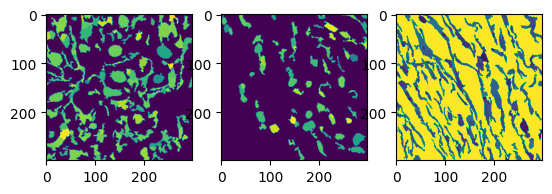

In [4]:
Selection_region_FFPE = list(test_dataset_FFPE.obs["tile_path"][0:3])

# Run LIME Function
LIMEMask_FFPE1 = LIME_exceptional_handling(Selection_region_FFPE,gene_list[15])

# Plot LIME Heatmap
plt.subplot(1,3,1)
plt.imshow(LIMEMask_FFPE1[0])
plt.subplot(1,3,2)
plt.imshow(LIMEMask_FFPE1[1])
plt.subplot(1,3,3)
plt.imshow(LIMEMask_FFPE1[2])

#### SHAP Global
https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.39s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.48s/it]               


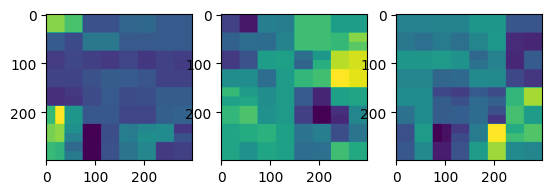

In [5]:
image_dir1 = list(test_dataset_FFPE.obs["tile_path"][0:1])
STimage_classification_classes = ["Low","High"]

FFPE_CD52_ShapMask = SHAP_global(image_dir1,gene_list[15])
FFPE_CD52_ShapMask_scaled = SHAP_scale(FFPE_CD52_ShapMask,len(image_dir1))

# Plot LIME Heatmap
plt.subplot(1,3,1)
plt.imshow(FFPE_CD52_ShapMask_scaled[0])
plt.subplot(1,3,2)
plt.imshow(FFPE_CD52_ShapMask_scaled[1])
plt.subplot(1,3,3)
plt.imshow(FFPE_CD52_ShapMask_scaled[2])

#### SHAP Agnostic
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html

  0%|          | 0/1 [00:00<?, ?it/s]

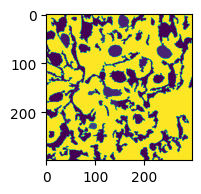

In [49]:
image_dir1 = list(test_dataset_FFPE.obs["tile_path"][0:3])
ffpe_shap_values_CD24_agnostic = []; ffpe_shap_segments_CD24_agnostic = []
for i in range(0,len(image_dir1)):
    image = Image.open(image_dir1[i])
    image_orig = img_to_array(image)
    segments_slic = watershed_segment(image)
    ffpe_shap_segments_CD24_agnostic.append(segments_slic)
    explainer = shap.KernelExplainer(model_predict_gene_kernel_reg("CD24"), np.zeros((1,ffpe_shap_segments_CD24_agnostic[i].max())))
    ffpe_shap_values_CD24_agnostic.append(explainer.shap_values(np.ones((1,ffpe_shap_segments_CD24_agnostic[i].max())), nsamples=ffpe_shap_segments_CD24_agnostic[i].max()))

ffpe_shap_segments_CD24_agnostic_scores = [] 
for j in range(0,len(image_dir1)):
    out = np.zeros((299,299))
    for i in range(0,ffpe_shap_segments_CD24_agnostic[j].max()):
        out[ffpe_shap_segments_CD24_agnostic[j] == i] = ffpe_shap_values_CD24_agnostic[j][0][0][i]
    ffpe_shap_segments_CD24_agnostic_scores.append(out)
        
plt.subplot(1,3,1)
plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[0])
plt.subplot(1,3,2)
plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[1])
plt.subplot(1,3,3)
plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[2])

  0%|          | 0/1 [00:00<?, ?it/s]

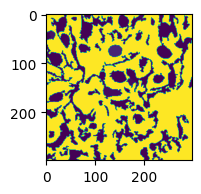

In [13]:
image_dir1 = list(test_dataset_FFPE.obs["tile_path"][0:1])
ffpe_shap_values_CD52_agnostic = []; ffpe_shap_segments_CD52_agnostic = []
for i in range(0,len(image_dir1)):
    image = Image.open(image_dir1[i])
    image_orig = img_to_array(image)
    segments_slic = watershed_segment(image)
    ffpe_shap_segments_CD52_agnostic.append(segments_slic)
    explainer_c = shap.KernelExplainer(model_predict_gene_kernel("CD52"), np.zeros((1,ffpe_shap_segments_CD52_agnostic[i].max())))
    ffpe_shap_values_CD52_agnostic.append(explainer_c.shap_values(np.ones((1,ffpe_shap_segments_CD52_agnostic[i].max())), nsamples=ffpe_shap_segments_CD52_agnostic[i].max()))

ffpe_shap_segments_CD52_agnostic_scores = [] 
for j in range(0,len(image_dir1)):
    out = np.zeros((299,299))
    for i in range(0,ffpe_shap_segments_CD52_agnostic[j].max()):
        out[ffpe_shap_segments_CD52_agnostic[j] == i] = ffpe_shap_values_CD52_agnostic[j][0][0][i]
    ffpe_shap_segments_CD52_agnostic_scores.append(out)
        
plt.subplot(1,3,1)
plt.imshow(ffpe_shap_segments_CD52_agnostic_scores[0])
# plt.subplot(1,3,2)
# plt.imshow(ffpe_shap_segments_CD52_agnostic_scores[1])
# plt.subplot(1,3,3)
# plt.imshow(ffpe_shap_segments_CD52_agnostic_scores[2])

### CD24

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Images with segmentation issues: []


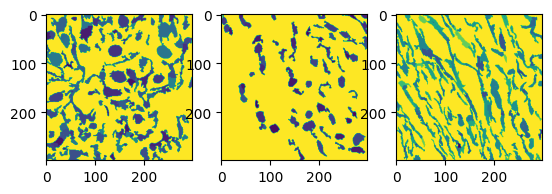

In [21]:
Selection_region_FFPE = list(test_dataset_FFPE.obs["tile_path"][0:3])

# Run LIME Function
LIMEMask_FFPE2 = LIME_exceptional_handling(Selection_region_FFPE,gene_list[71])

# Plot LIME Heatmap
plt.subplot(1,3,1)
plt.imshow(LIMEMask_FFPE2[0])
plt.subplot(1,3,2)
plt.imshow(LIMEMask_FFPE2[1])
plt.subplot(1,3,3)
plt.imshow(LIMEMask_FFPE2[2])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.35s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.23s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.76s/it]               


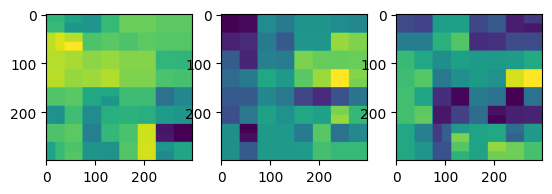

In [16]:
image_dir1 = list(test_dataset_FFPE.obs["tile_path"][0:3])
STimage_classification_classes = ["Low","High"]

FFPE_CD24_ShapMask = SHAP_global(image_dir1,gene_list[71])
FFPE_CD24_ShapMask_scaled = SHAP_scale(FFPE_CD24_ShapMask,len(image_dir1))

# Plot LIME Heatmap
plt.subplot(1,3,1)
plt.imshow(FFPE_CD24_ShapMask_scaled[0])
plt.subplot(1,3,2)
plt.imshow(FFPE_CD24_ShapMask_scaled[1])
plt.subplot(1,3,3)
plt.imshow(FFPE_CD24_ShapMask_scaled[2])

In [1]:
# ffpe_shap_values_CD24_agnostic = []; ffpe_shap_segments_CD24_agnostic = []
# for i in range(0,len(image_dir1)):
#     image = Image.open(image_dir1[i])
#     image_orig = img_to_array(image)
#     segments_slic = watershed_segment(image)
#     ffpe_shap_segments_CD24_agnostic.append(segments_slic)
#     explainer = shap.KernelExplainer(model_predict_gene_kernel("CD24"), np.zeros((1,ffpe_shap_segments_CD24_agnostic[i].max())))
#     ffpe_shap_values_CD24_agnostic.append(explainer.shap_values(np.ones((1,ffpe_shap_segments_CD24_agnostic[i].max())), nsamples=ffpe_shap_segments_CD24_agnostic[i].max()))

# ffpe_shap_segments_CD24_agnostic_scores = [] 
# for j in range(0,len(image_dir1)):
#     out = np.zeros((299,299))
#     for i in range(0,ffpe_shap_segments_CD24_agnostic[j].max()):
#         out[ffpe_shap_segments_CD24_agnostic[j] == i] = ffpe_shap_values_CD24_agnostic[j][0][0][i]
#     ffpe_shap_segments_CD24_agnostic_scores.append(out)
        
# plt.subplot(1,3,1)
# plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[0])
# plt.subplot(1,3,2)
# plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[1])
# plt.subplot(1,3,3)
# plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[2])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

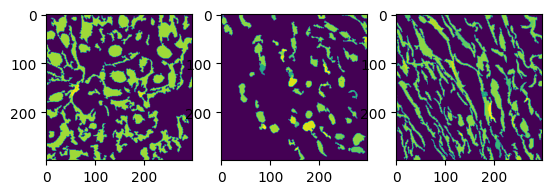

In [17]:
ffpe_shap_values_CD24_agnostic = []; ffpe_shap_segments_CD24_agnostic = []
for i in range(0,len(image_dir1)):
    image = Image.open(image_dir1[i])
    image_orig = img_to_array(image)
    segments_slic = watershed_segment(image)
    ffpe_shap_segments_CD24_agnostic.append(segments_slic)
    explainer = shap.KernelExplainer(model_predict_gene_kernel("CD24"), np.zeros((1,ffpe_shap_segments_CD24_agnostic[i].max())))
    ffpe_shap_values_CD24_agnostic.append(explainer.shap_values(np.ones((1,ffpe_shap_segments_CD24_agnostic[i].max())), nsamples=ffpe_shap_segments_CD24_agnostic[i].max()))

ffpe_shap_segments_CD24_agnostic_scores = [] 
for j in range(0,len(image_dir1)):
    out = np.zeros((299,299))
    for i in range(0,ffpe_shap_segments_CD24_agnostic[j].max()):
        out[ffpe_shap_segments_CD24_agnostic[j] == i] = ffpe_shap_values_CD24_agnostic[j][0][0][i]
    ffpe_shap_segments_CD24_agnostic_scores.append(out)
        
plt.subplot(1,3,1)
plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[0])
plt.subplot(1,3,2)
plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[1])
plt.subplot(1,3,3)
plt.imshow(ffpe_shap_segments_CD24_agnostic_scores[2])

#### Compare segments

In [34]:
LIMEMask_scd = scale_mask(np.array(LIMEMask_FFPE),3)
LIMEMask2_scd = scale_mask(np.array(LIMEMask_FFPE2),3)
LIME_segment_score_FFPE_CD52 = LIME_segment_score(image_dir1,
                                                      LIMEMask_scd)
LIME_segment_score_FFPE_CD24 = LIME_segment_score(image_dir1,
                                                      LIMEMask2_scd)
LIME_df_CD52 = pd.DataFrame(LIMEMask_scd.reshape(3,89401))
LIME_df_CD24 = pd.DataFrame(LIMEMask2_scd.reshape(3,89401))
FFPE_result_df = pd.concat([LIME_df_CD52, LIME_df_CD24], ignore_index=True)
FFPE_lime = LIME_compare(LIMEMask_FFPE2,LIMEMask_FFPE)

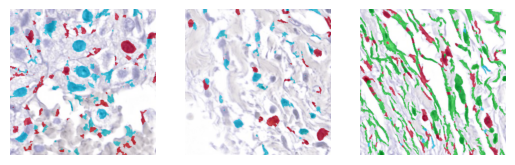

In [35]:
# plt.figure(figsize=(15,40))
for i in range(len(image_dir1)):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(255-FFPE_lime[i])
    plt.imshow(Image.open(image_dir1[i]),alpha=0.5)